In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, models, layers, callbacks
from sklearn.utils import class_weight

from prosenet import ProSeNet, PrototypeProjection, datasets, ops

In [2]:
# Set any non-default args
new_rnn_args = {
    'layers' : [32, 32, 32],
    'layer_args' : {
        'dropout' : 0.1,
        'activity_regularizer' : regularizers.l2(0.1)    # Note: not in paper
    }
}

new_proto_args = {
    'dmin' : 2.0,
    'Ld' : 0.01, #0.1,
    'Lc' : 0.0,
    'Le' : 1.0
}

pnet = ProSeNet(input_shape=(187, 1), 
                nclasses=5, 
                k=30, 
                rnn_args=new_rnn_args,
                prototypes_args=new_proto_args,
                L1=0.1)

pnet.build( (None, 187, 1) )

pnet.summary()

Model: "pro_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64)                58368     
_________________________________________________________________
prototypes (Prototypes)      multiple                  1920      
_________________________________________________________________
classifier (Dense)           multiple                  150       
Total params: 60,438
Trainable params: 60,438
Non-trainable params: 0
_________________________________________________________________


-0.25259262 0.25264427


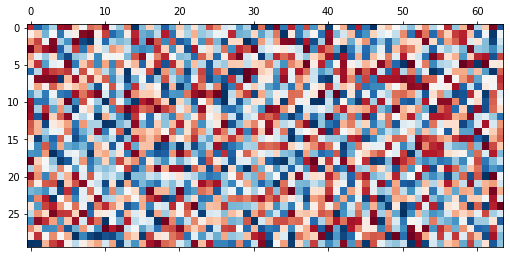

In [3]:
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
print(protos.min(), protos.max())

plt.matshow(protos, cmap=plt.cm.RdBu)

-0.41134965 0.4021702


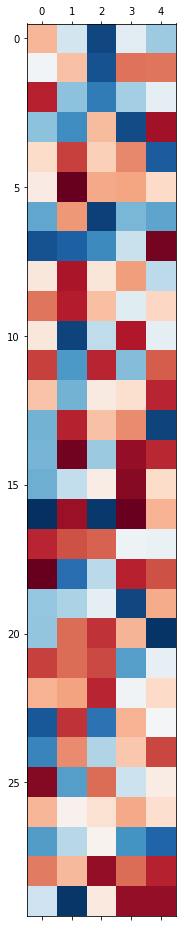

In [4]:
pred_weights = np.squeeze(pnet.classifier.weights[0].numpy())
print(pred_weights.min(), pred_weights.max())

plt.matshow(pred_weights, cmap=plt.cm.RdBu)

In [5]:
data = datasets.ArrhythmiaDataset('../data/')
print(data)

MIT-BIH Arrhythmia Dataset
Num classes: 5
Input shape: (187, 1)



In [6]:
train_gen = datasets.DataGenerator(data.X_train, data.y_train, batch_size=128)

test_gen = datasets.DataGenerator(data.X_test, data.y_test, batch_size=128)

class_weights = 1 - (np.bincount(np.argmax(data.y_train, 1)) / data.y_train.shape[0])

# Setting class 0 to 0.001, need to just get it to stop overfitting that class
#class_weights[0] = 0.0
class_weights

array([0.17227083, 0.97460995, 0.93389223, 0.9926788 , 0.92654819])

# First train just the `encoder`

In [7]:
pnet.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 187, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 187, 64)           24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
Total params: 58,368
Trainable params: 58,368
Non-trainable params: 0
_________________________________________________________________


In [8]:
x_encoded = pnet.encoder.output

pred = layers.Dense(5, activation='softmax')(x_encoded)

encoder_classifier = models.Model(inputs=pnet.encoder.input, outputs=pred)

encoder_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 187, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 187, 64)           24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 58,693
Trainable params: 58,693
Non-trainable params: 0
_________________________________________________________________


In [9]:
rms = optimizers.RMSprop()

encoder_classifier.trainable = True

encoder_classifier.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(patience=3)

encoder_classifier.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=10,
                   callbacks=[early_stopping],
                   class_weight=class_weights,
                   shuffle=False)

Epoch 1/10
685/685 [==============================] - 70s 102ms/step - loss: 1.0958 - accuracy: 0.8293 - val_loss: 0.6135 - val_accuracy: 0.8477
Epoch 2/10
685/685 [==============================] - 69s 100ms/step - loss: 0.4861 - accuracy: 0.8809 - val_loss: 0.5000 - val_accuracy: 0.8683
Epoch 3/10
685/685 [==============================] - 69s 100ms/step - loss: 0.4090 - accuracy: 0.9062 - val_loss: 0.4251 - val_accuracy: 0.9055
Epoch 4/10
685/685 [==============================] - 68s 100ms/step - loss: 0.3565 - accuracy: 0.9214 - val_loss: 0.3301 - val_accuracy: 0.9269
Epoch 5/10
685/685 [==============================] - 70s 102ms/step - loss: 0.3052 - accuracy: 0.9343 - val_loss: 0.4781 - val_accuracy: 0.8956
Epoch 6/10
685/685 [==============================] - 68s 100ms/step - loss: 0.2777 - accuracy: 0.9402 - val_loss: 0.3401 - val_accuracy: 0.9253
Epoch 7/10
685/685 [==============================] - 69s 100ms/step - loss: 0.2619 - accuracy: 0.9439 - val_loss: 0.2381 - val_ac

In [10]:
pnet.encoder.predict(data.X_train[:1,:])

array([[-0.00901509,  0.03825881,  0.01547774,  0.05268815, -0.03155208,
         0.02806929,  0.02765575,  0.01600046,  0.01558299, -0.07518127,
         0.00527323,  0.04127062, -0.02085822, -0.02696913,  0.0035431 ,
         0.01423474,  0.03940349, -0.03423197, -0.04536817, -0.01575064,
         0.05303091,  0.05507685,  0.04581413, -0.0082277 ,  0.01208533,
        -0.03487886,  0.05182993,  0.03349828, -0.06513403, -0.03467173,
         0.04699871,  0.06339042,  0.01715292,  0.00659781,  0.00323452,
        -0.08702888, -0.08091197,  0.00652994,  0.08654818,  0.00995399,
        -0.04873883,  0.02052765, -0.22491825,  0.12993301, -0.04558599,
        -0.01832178, -0.04427263, -0.06047248,  0.03061571,  0.04527801,
        -0.04022387,  0.03021744,  0.04104913,  0.0768979 ,  0.04916644,
         0.05889302, -0.0254725 ,  0.14688689, -0.06120417, -0.02469384,
         0.01247844, -0.10996326, -0.03999504,  0.07323352]],
      dtype=float32)

# Now freeze the `encoder` and train the prototypes head

In [11]:
# Freeze the encoder
pnet.encoder.trainable = False

In [12]:
# Define come `Callback`s

# 1.0 seems pretty high... but we'll follow the paper.
init_lr = 0.1 # 1.0

def lr_schedule(epoch):
    if epoch <= 10:
        return init_lr
    else:
        return init_lr * 0.85**(epoch - 10)
    
lr_schedule = callbacks.LearningRateScheduler(lr_schedule)

early_stopping = callbacks.EarlyStopping(patience=3)

projection = PrototypeProjection(train_gen, freq=4)

In [13]:
sgd = optimizers.SGD(learning_rate=init_lr, clipnorm=5.0)

pnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

pnet.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=26,
                   callbacks=[early_stopping, lr_schedule, projection],
                   class_weight=class_weights,
                   shuffle=False)

Epoch 1/26
684/685 [============================>.] - ETA: 0s - loss: 1029.1771 - accuracy: 0.8073Computing prototype projection...


NameError: name 'tf' is not defined

# Diagnostics

In [ ]:
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
print(protos.min(), protos.max())

plt.matshow(protos, cmap=plt.cm.RdBu)

In [ ]:
pred_weights = np.squeeze(pnet.classifier.weights[0].numpy())
print(pred_weights.min(), pred_weights.max())

plt.matshow(pred_weights, cmap=plt.cm.RdBu)

In [ ]:
pnet.predict(data.X_train[:3,:], batch_size=1)

In [ ]:
data.y_train[:3]

In [ ]:
pnet.predict(data.X_test[-3:,:], batch_size=1)

In [ ]:
data.y_test[-3:]

In [ ]:
plt.plot(np.arange(187), data.X_train[-2])

In [ ]:
class_weights

In [ ]:
pnet.classifier.weights

In [ ]:
encoder_classifier.layers[-1].weights

In [ ]:
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
protos

In [ ]:
plt.matshow(protos, cmap=plt.cm.RdBu)

In [ ]:
pnet.encoder.predict(data.X_train[-2:,:])

In [ ]:
pnet.encoder.predict(data.X_train[:2,:])

In [ ]:
pnet.prototypes_layer._diversity_term()

In [ ]:
pnet.losses